
<div style="text-align: center; font-size: 20px; margin-top: 10px; margin-bottom: 20px;">
    M9 · Deep Learning aplicada – Visión artificial (Intel Scenes)
</div>
<div style="text-align: center; font-size: 36px; font-weight: bold; margin-top: 10px; margin-bottom: 20px;">
    Clasificación multiclase 150×150 · 6 etiquetas
</div>

<p style="text-align: center;">
    <img src="https://upload.wikimedia.org/wikipedia/commons/f/fd/IMF_Smart_Education.png" alt="IMF Smart Education" width="300"/>
</p>

---

<div style="text-align: center; font-size: 28px; font-weight: bold; margin-top: 10px; margin-bottom: 20px;">
    Proyecto desarrollado por Diego Cesar Lerma Torres para IMF Smart Education
</div>

> Caso práctico del módulo **M9**  
> _Deep learning aplicada: NLP y visión artificial_  
> _Del Master en Inteligencia Artificial_

---

Este proyecto aplica técnicas avanzadas de **deep learning** para clasificar imágenes de escenas, combinando diversas áreas del conocimiento en inteligencia artificial.

# Dataset

**Intel Image Classification Dataset**

Este conjunto de datos contiene imágenes de escenas naturales alrededor del mundo, capturadas en distintas condiciones y escenarios. El objetivo es clasificar cada imagen en una de seis categorías diferentes.

- **Número de imágenes**: Aproximadamente 25,000.
- **Dimensiones**: 150x150 píxeles por imagen.
- **Categorías**:
  - 0: Buildings (edificios)
  - 1: Forest (bosque)
  - 2: Glacier (glaciar)
  - 3: Mountain (montaña)
  - 4: Sea (mar)
  - 5: Street (calle)
  
- **Estructura del dataset**:
  - **Entrenamiento (Train)**: ~14,000 imágenes.
  - **Pruebas (Test)**: ~3,000 imágenes.
  - **Predicción (Prediction)**: ~7,000 imágenes.

Cada partición está disponible en archivos comprimidos independientes.

**Fuente**: El dataset fue inicialmente publicado en [Analytics Vidhya](https://datahack.analyticsvidhya.com) por Intel como parte de un desafío de clasificación de imágenes.

**Objetivo del proyecto**:  
El propósito principal de este conjunto de datos es servir de base para el entrenamiento de redes neuronales profundas (CNNs) capaces de clasificar escenas naturales con alta precisión, fortaleciendo habilidades en visión artificial y aprendizaje profundo.

> Agradecimientos a Intel y Analytics Vidhya por proporcionar este valioso recurso para la comunidad.


# Configuración inicial

In [50]:
# !pip install -r requirements.txt

# En local
%pip install -r ../requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Subir el kaggle.json, en caso de querer descargar directamente la base de datos de su origen

#from google.colab import files
#files.upload()

In [3]:
# Mover el archivo descargado a su lugar

#!mkdir -p ~/.kaggle
#!mv kaggle.json ~/.kaggle/
#!chmod 600 ~/.kaggle/kaggle.json


In [51]:
import os
import json
import zipfile
import random
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, mixed_precision
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import keras_tuner as kt

mixed_precision.set_global_policy('mixed_float16')

SEED               = 42
IMG_SIZE           = (150, 150)
BATCH_SIZE         = 64
EPOCHS             = 50
VAL_SPLIT          = 0.20
TEST_SPLIT         = 0.25
AUTOTUNE           = tf.data.AUTOTUNE
PROJECT_ROOT       = Path('../')
DATA_DIR           = PROJECT_ROOT/'data'
FULL_DATA  = DATA_DIR / 'data_all'
MODELS_DIR         = PROJECT_ROOT/'models'
HIST_DIR           = PROJECT_ROOT/'history'
for d in (DATA_DIR, FULL_DATA, MODELS_DIR, HIST_DIR):
    d.mkdir(parents=True, exist_ok=True)

random.seed(SEED);
np.random.seed(SEED);
tf.random.set_seed(SEED)
print(tf.__version__)

2.19.0


Ejecutar solo la primera vez.
Descargar y descomprimir desde Kaggle

Las siguientes veces, esta sección debe comentarse u omitirse su ejecución

In [ ]:
!kaggle datasets download -d puneet6060/intel-image-classification -p {PROJECT_ROOT}


In [6]:
with zipfile.ZipFile(PROJECT_ROOT/'intel-image-classification.zip') as z: z.extractall(DATA_DIR)


# 1. Descarga y unificación de carpetas seg_train + seg_test

In [14]:

"""# 1. Unificación de carpetas seg_train + seg_test"""

import shutil

def merge_folders_corrected(src_root: Path, dst_root: Path):
    """
    Fusiona las imágenes de las subcarpetas de clase encontradas dentro de
    src_root/seg_train/seg_train/<clase> y src_root/seg_test/seg_test/<clase>
    en dst_root/<clase>.
    Elimina las carpetas originales seg_train/ y seg_test/ de src_root después.
    """
    print(f"Iniciando fusión de carpetas desde {src_root} hacia {dst_root}")
    dst_root.mkdir(parents=True, exist_ok=True)

    split_names = ['seg_train', 'seg_test']

    for split in split_names:
        split_base_dir = src_root / split
        print(f"Procesando división: {split}")

        nested_split_dir = split_base_dir / split

        if nested_split_dir.exists() and nested_split_dir.is_dir():
            print(f"  Encontrada estructura anidada en: {nested_split_dir}")
            source_class_dir_parent = nested_split_dir
        elif split_base_dir.exists() and split_base_dir.is_dir():
             contains_class_dirs = any(item.is_dir() for item in split_base_dir.iterdir())
             if contains_class_dirs:
                 print(f"  Estructura anidada no encontrada, usando directorio base: {split_base_dir}")
                 source_class_dir_parent = split_base_dir
             else:
                 print(f"  Directorio {split_base_dir} no contiene subdirectorios de clase esperados. Omitiendo.")
                 continue
        else:
            print(f"  Directorio base {split_base_dir} no encontrado o no es un directorio. Omitiendo.")
            continue

        class_count = 0
        image_count = 0
        for class_dir in source_class_dir_parent.iterdir():
            if class_dir.is_dir():
                class_name = class_dir.name
                target_class_dir = dst_root / class_name
                target_class_dir.mkdir(parents=True, exist_ok=True)
                class_count += 1

                files_in_class = list(class_dir.iterdir())
                print(f"    Procesando clase '{class_name}' ({len(files_in_class)} archivos)...")
                for img_path in files_in_class:
                    if img_path.is_file():
                        dst_img_path = target_class_dir / img_path.name
                        try:
                            shutil.move(str(img_path), str(dst_img_path))
                            image_count += 1
                        except Exception as e:
                            print(f"      Error moviendo {img_path.name} a {target_class_dir}: {e}")

        print(f"  Procesadas {class_count} clases y {image_count} imágenes para la división '{split}'.")

    print("\nLimpiando carpetas originales...")
    for split in split_names:
        original_split_dir = src_root / split
        if original_split_dir.exists():
            try:
                shutil.rmtree(original_split_dir)
                print(f"  Eliminada carpeta: {original_split_dir}")
            except OSError as e:
                print(f"  Error eliminando {original_split_dir}: {e}")
        else:
            print(f"  La carpeta {original_split_dir} no existe, no se necesita eliminar.")

    print(f"\nFusión completada. Datos unificados en: {dst_root}")



In [ ]:
if DATA_DIR.exists():
    merge_folders_corrected(DATA_DIR, FULL_DATA)
else:
    print(f"ERROR: El directorio de origen {DATA_DIR} no existe. No se puede ejecutar la fusión.")

if FULL_DATA.exists():
    print("\nContenido del directorio unificado (data_all):")
    class_names_merged = sorted([d.name for d in FULL_DATA.iterdir() if d.is_dir()])
    print(f"Clases encontradas: {class_names_merged}")
    total_images = 0
    for class_dir in FULL_DATA.iterdir():
        if class_dir.is_dir():
            count = len(list(class_dir.glob('*.*')))
            print(f"- {class_dir.name}: {count} imágenes")
            total_images += count
    print(f"Total imágenes unificadas: {total_images}")
else:
    print(f"ERROR: El directorio destino {FULL_DATA} no se creó correctamente.")



# 2. Generadores de imágenes

In [28]:
def build_dataset(directory, img_size=IMG_SIZE, batch_size=BATCH_SIZE,
                  test_split=TEST_SPLIT, seed=SEED):

    ds_full = tf.keras.utils.image_dataset_from_directory(
        directory,
        image_size=img_size,
        batch_size=batch_size,
        shuffle=True,
        seed=seed,
        label_mode='int')

    class_names = ds_full.class_names


    total      = ds_full.cardinality().numpy()
    test_count = int(total * test_split)

    test_ds    = ds_full.take(test_count)
    train_val  = ds_full.skip(test_count)

    val_count  = int(train_val.cardinality().numpy() * VAL_SPLIT)
    val_ds     = train_val.take(val_count)
    train_ds   = train_val.skip(val_count)


    train_ds = train_ds.cache().prefetch(AUTOTUNE)
    val_ds   = val_ds.cache().prefetch(AUTOTUNE)
    test_ds  = test_ds.cache().prefetch(AUTOTUNE)

    return train_ds, val_ds, test_ds, class_names


In [29]:
train_ds, val_ds, test_ds, class_names = build_dataset(FULL_DATA)
NUM_CLASSES = len(class_names)
print(class_names)

Found 17034 files belonging to 6 classes.
['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [30]:
for cls in sorted((FULL_DATA).iterdir()):
    print(f"{cls.name:<10}  {len(list(cls.glob('*'))):5d} imágenes")

# Debe mostrarse que existen varias imagenes repartidas en 6 carpetas. De lo contrario, revisar antes de comenzar el entrenamiento.

buildings    2628 imágenes
forest       2745 imágenes
glacier      2957 imágenes
mountain     3037 imágenes
sea          2784 imágenes
street       2883 imágenes


# 3. Callbacks comunes

In [52]:
def common_callbacks(name):
    return [
        EarlyStopping(monitor='val_loss',
                      patience=5,
                      restore_best_weights=True),

        ModelCheckpoint(MODELS_DIR/f'{name}.keras',
                        monitor='val_loss',
                        save_best_only=True),

        ReduceLROnPlateau(monitor='val_loss',
                          patience=2,
                          factor=0.3,
                          verbose=1)
    ]


In [53]:
def get_optimizer(lr=1e-3):
    """Crea un optimizador Adam envuelto en LossScaleOptimizer."""
    base_opt = tf.keras.optimizers.Adam(learning_rate=lr)
    return mixed_precision.LossScaleOptimizer(base_opt)

# 4. Modelo 1 — CNN Base

In [33]:
def cnn_base(input_shape=IMG_SIZE+(3,), num_classes=NUM_CLASSES):
    model = tf.keras.Sequential([
        tf.keras.Input(shape=input_shape),
        layers.Rescaling(1./255),
        layers.Conv2D(32, 3, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(),
        layers.GlobalAveragePooling2D(),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ], name='cnn_base')

    model.compile(optimizer=get_optimizer(1e-3),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model


In [34]:
print("\n--- Entrenando Modelo Base ---")
base_model = cnn_base()
base_model.summary()

history_base = base_model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=common_callbacks('base_model')
)

# Guardar historial
print("Guardando historial de Modelo Base v2...")
json.dump(history_base.history, open(HIST_DIR/'base_model.json','w'))


--- Entrenando Modelo Base ---


Model: "cnn_base"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)         │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 150, 150, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 150, 150, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,494 (13.65 KB)

 Trainable params: 3,430 (13.40 KB)

 Non-trainable params: 64 (256.00 B)

Epoch 1/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.3829 - loss: 1.5492 - val_accuracy: 0.2289 - val_loss: 1.6952 - learning_rate: 0.0010
Epoch 2/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5488 - loss: 1.1839 - val_accuracy: 0.3965 - val_loss: 1.4517 - learning_rate: 0.0010
Epoch 3/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5994 - loss: 1.0603 - val_accuracy: 0.5152 - val_loss: 1.1258 - learning_rate: 0.0010
Epoch 4/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6252 - loss: 0.9870 - val_accuracy: 0.5527 - val_loss: 1.0711 - learning_rate: 0.0010
Epoch 5/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6451 - loss: 0.9397 - val_accuracy: 0.5301 - val_loss: 1.1670 - learning_rate: 0.0010
Epoch 6/50
156/161 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6575 - loss: 0.9051
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6579 - loss: 0.9046 - 

# 5. Modelo 2 — CNN Avanzada (más profundidad + Dropout + BatchNorm)

In [38]:
def cnn_advanced(input_shape=IMG_SIZE+(3,), num_classes=NUM_CLASSES):
    """
    Versión 3: Filtros [32, 64, 64], Orden Conv->BN->Activation
    """
    inputs = layers.Input(shape=input_shape)
    x = layers.Rescaling(1./255)(inputs)

    for filters in [32, 64, 64]:
        x = layers.Conv2D(filters, 3, padding='same', use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)

        x = layers.Conv2D(filters, 3, padding='same', use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)

        x = layers.MaxPooling2D()(x)
        x = layers.Dropout(0.20)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.40)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs, name='cnn_advanced')

    model.compile(optimizer=get_optimizer(5e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [40]:
print("\n--- Creando y Verificando CNN Advanced ---")
adv_model_instance = cnn_advanced()

print("--- Model Summary ---")
adv_model_instance.summary(line_length=100)

callbacks = [tf.keras.callbacks.TerminateOnNaN()] + common_callbacks('advance_model')


print("\n--- Iniciando entrenamiento CNN Advanced ---")
history_adv = adv_model_instance.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=callbacks
)

print("Guardando historial de CNN Avanzado...")
json.dump(history_adv.history, open(HIST_DIR/'advance_model.json','w'))


--- Creando y Verificando CNN Advanced ---
--- Model Summary ---


Model: "cnn_advanced"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                               ┃ Output Shape                    ┃           Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)                 │ (None, 150, 150, 3)             │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ cast_42 (Cast)                             │ (None, 150, 150, 3)             │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ rescaling_5 (Rescaling)                    │ (None, 150, 150, 3)             │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ conv2d_20 (Conv2D)                         │ (None, 150, 150, 32)            │               864 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ batch_normalization_16                     │ (None, 150, 150, 32)            │               128 │
│ (BatchNormalization)                       │                                 │                   │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ activation_13 (Activation)                 │ (None, 150, 150, 32)            │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ conv2d_21 (Conv2D)                         │ (None, 150, 150, 32)            │             9,216 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ batch_normalization_17                     │ (None, 150, 150, 32)            │               128 │
│ (BatchNormalization)                       │                                 │                   │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ activation_14 (Activation)                 │ (None, 150, 150, 32)            │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ max_pooling2d_11 (MaxPooling2D)            │ (None, 75, 75, 32)              │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ dropout_12 (Dropout)                       │ (None, 75, 75, 32)              │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ conv2d_22 (Conv2D)                         │ (None, 75, 75, 64)              │            18,432 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ batch_normalization_18                     │ (None, 75, 75, 64)              │               256 │
│ (BatchNormalization)                       │                                 │                   │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ activation_15 (Activation)                 │ (None, 75, 75, 64)              │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ conv2d_23 (Conv2D)                         │ (None, 75, 75, 64)              │            36,864 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ batch_normalization_19                     │ (None, 75, 75, 64)              │               256 │
│ (BatchNormalization)                       │                                 │                   │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ activation_16 (Activation)                 │ (None, 75, 75,

 Total params: 5,450,598 (20.79 MB)

 Trainable params: 5,449,958 (20.79 MB)

 Non-trainable params: 640 (2.50 KB)


--- Iniciando entrenamiento CNN Advanced ---
Epoch 1/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.2433 - loss: 8.4697

2025-04-28 17:30:33.876186: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_183', 248 bytes spill stores, 248 bytes spill loads



161/161 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.2439 - loss: 8.4543 - val_accuracy: 0.2680 - val_loss: 2.0326 - learning_rate: 5.0000e-04
Epoch 2/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.5747 - loss: 1.2600 - val_accuracy: 0.2816 - val_loss: 1.9575 - learning_rate: 5.0000e-04
Epoch 3/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.6521 - loss: 0.9817 - val_accuracy: 0.3648 - val_loss: 1.8716 - learning_rate: 5.0000e-04
Epoch 4/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.7072 - loss: 0.8006 - val_accuracy: 0.6164 - val_loss: 1.0116 - learning_rate: 5.0000e-04
Epoch 5/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.7538 - loss: 0.7030 - val_accuracy: 0.6395 - val_loss: 0.9872 - learning_rate: 5.0000e-04
Epoch 6/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.7763 - loss: 0.6337 - val_accuracy: 0.7648 - val_loss: 0.7041 - learning_rate: 5.0000e-04
Epoch 7/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.8

# 6. Modelo 3 — Hyperparameter Tuning (Keras Tuner)

In [58]:
def model_builder(hp):
    """Define el modelo basado en la arquitectura funcional."""

    hp_filters = hp.Choice('filters', values=[32, 48, 64])
    hp_activation = hp.Choice('activation', values=['relu', 'swish'])
    hp_pooling = hp.Choice('pooling', ['flatten', 'global_avg'])
    hp_dense_units = hp.Int('dense_units', min_value=64, max_value=256, step=64)
    hp_dropout_conv = hp.Float('dropout_conv', min_value=0.1, max_value=0.3, step=0.05)
    hp_dropout_dense = hp.Float('dropout_dense', min_value=0.2, max_value=0.5, step=0.1)
    hp_l2 = hp.Float('l2', min_value=1e-6, max_value=1e-4, sampling='log')
    hp_lr = hp.Choice('learning_rate', values=[1e-3, 5e-4, 1e-4])

    inputs = layers.Input(shape=IMG_SIZE + (3,))
    x = layers.Rescaling(1./255)(inputs)

    filter_progression = [hp_filters, hp_filters * 2, hp_filters * 4]

    for filters in filter_progression:
        x = layers.Conv2D(filters, 3, padding='same', use_bias=False,
                          kernel_regularizer=tf.keras.regularizers.l2(hp_l2))(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation(hp_activation)(x)

        x = layers.Conv2D(filters, 3, padding='same', use_bias=False,
                          kernel_regularizer=tf.keras.regularizers.l2(hp_l2))(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation(hp_activation)(x)

        x = layers.MaxPooling2D()(x)
        x = layers.Dropout(hp_dropout_conv)(x)

    if hp_pooling == 'flatten':
        x = layers.Flatten()(x)
    else:
        x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dense(hp_dense_units, activation=hp_activation,
                     kernel_regularizer=regularizers.l2(hp_l2))(x)
    x = layers.Dropout(hp_dropout_dense)(x)
    outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)

    optimizer = tf.keras.optimizers.Adam(learning_rate=hp_lr) # Mantener Adam por ahora

    optimizer = mixed_precision.LossScaleOptimizer(optimizer)

    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [60]:
tuner = kt.Hyperband(
    model_builder,
    objective='val_accuracy',
    max_epochs=20,
    factor=3,
    hyperband_iterations=1,
    directory='kt_logs_hyperband',
    project_name='intel_hp_hyperband_v2',
    overwrite=True)

search_callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=3)
]

print(f"Iniciando búsqueda de hiperparámetros con Hyperband (max_epochs=20)...")
tuner.search(train_ds,
             validation_data=val_ds,
             callbacks=search_callbacks)

print("\nBúsqueda completada. Obteniendo y re-entrenando el mejor modelo...")

best_hp = tuner.get_best_hyperparameters(1)[0]
print("Mejores Hiperparámetros encontrados:")
for param, value in best_hp.values.items():
    print(f"- {param}: {value}")

best_hp_model = tuner.hypermodel.build(best_hp)
best_hp_model.summary()

best_hp_model.save(MODELS_DIR / 'hp_best_structure_untrained.keras', include_optimizer=False)

print("\n--- Iniciando entrenamiento FINAL del mejor modelo HP ---")

final_history_hp = best_hp_model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,

    callbacks=common_callbacks('hp')
)

print("Guardando historial y modelo final HP...")
json.dump(final_history_hp.history, open(HIST_DIR / 'hp.json', 'w'))
best_hp_model.save(MODELS_DIR / 'hp.keras')

Trial 30 Complete [00h 01m 16s]
val_accuracy: 0.806640625

Best val_accuracy So Far: 0.841796875
Total elapsed time: 00h 27m 34s

Búsqueda completada. Obteniendo y re-entrenando el mejor modelo...
Mejores Hiperparámetros encontrados:
- filters: 48
- activation: swish
- pooling: global_avg
- dense_units: 64
- dropout_conv: 0.15000000000000002
- dropout_dense: 0.2
- l2: 3.5557471228176156e-06
- learning_rate: 0.0005
- tuner/epochs: 20
- tuner/initial_epoch: 7
- tuner/bracket: 1
- tuner/round: 1
- tuner/trial_id: 0020


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 150, 150, 48)   │         1,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 150, 150, 48)   │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 150, 150, 48)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 150, 150, 48)   │        20,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 150, 150, 48)   │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 150, 150, 48)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 75, 75, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 75, 75, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 75, 75, 96)     │        41,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 75, 75, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 75, 75, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 75, 75, 96)     │        82,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 75, 75, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 75, 75, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 37, 37, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 37, 37, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 37, 37, 192)    │       165,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 37, 37, 192)    │           768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 37, 37, 192)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 37, 37, 192)    │       331,776 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 659,542 (2.52 MB)

 Trainable params: 658,198 (2.51 MB)

 Non-trainable params: 1,344 (5.25 KB)


--- Iniciando entrenamiento FINAL del mejor modelo HP ---
Epoch 1/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 17s 73ms/step - accuracy: 0.5666 - loss: 1.0997 - val_accuracy: 0.1984 - val_loss: 3.2733 - learning_rate: 5.0000e-04
Epoch 2/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - accuracy: 0.7330 - loss: 0.6973 - val_accuracy: 0.4625 - val_loss: 1.6967 - learning_rate: 5.0000e-04
Epoch 3/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - accuracy: 0.7834 - loss: 0.5854 - val_accuracy: 0.7270 - val_loss: 0.7353 - learning_rate: 5.0000e-04
Epoch 4/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - accuracy: 0.8162 - loss: 0.5172 - val_accuracy: 0.7949 - val_loss: 0.5705 - learning_rate: 5.0000e-04
Epoch 5/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.8301 - loss: 0.4690 - val_accuracy: 0.8207 - val_loss: 0.4828 - learning_rate: 5.0000e-04
Epoch 6/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.8410 - loss: 0.4354 - val_accuracy: 0.8258 - val_loss: 0.4755 - learning_rate: 5.0000e-0

# 7. Modelo 4 — Transfer Learning + Fine Tuning


In [61]:
def transfer_finetune(base='MobileNetV2',
                      img_size=IMG_SIZE,
                      num_classes=NUM_CLASSES,
                      unfreeze_from=100,
                      hub_size=224):

    """Feature-extraction + fine-tuning con red pre-entrenada."""
    base_model = getattr(tf.keras.applications, base)(
        include_top=False,
        weights='imagenet',
        input_shape=(hub_size, hub_size, 3)
    )
    base_model.trainable = False

    inputs  = layers.Input(shape=img_size + (3,))
    x = layers.Resizing(hub_size, hub_size)(inputs)
    x = layers.Rescaling(1./255)(x)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs, name=f'{base}_finetune')

    opt_fe = get_optimizer(1e-3)
    model.compile(optimizer=opt_fe,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    hist_fe = model.fit(train_ds,
                        epochs=5,
                        validation_data=val_ds)

    opt_ft = get_optimizer(1e-5)

    base_model.trainable = True
    print(f"Fine-tuning: Descongelando desde la capa {unfreeze_from}")
    for i, layer in enumerate(base_model.layers):
        if i < unfreeze_from:
            layer.trainable = False
        else:
            if i % 10 == 0 or i >= len(base_model.layers) - 5:
              print(f"  - Capa {i} ({layer.name}): Trainable = {layer.trainable}")

    print("\nRe-compilando modelo para fine-tuning con LR bajo...")
    model.compile(optimizer=opt_ft,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])


    print("Iniciando fase de fine-tuning...")
    initial_epoch_ft = hist_fe.epoch[-1] + 1

    hist_ft = model.fit(train_ds,
                        epochs=EPOCHS,
                        validation_data=val_ds,
                        callbacks=common_callbacks('fine_tuning'))

    history = {k: hist_fe.history.get(k, []) + hist_ft.history[k]
               for k in hist_ft.history.keys()
               }
    return model, history


In [62]:
tl_model, history_ft = transfer_finetune()
json.dump(history_ft, open(HIST_DIR / 'fine_tuning.json', 'w'))
tl_model.save(MODELS_DIR / 'fine_tuning.keras', include_optimizer=False)

Epoch 1/5


2025-04-28 18:56:17.675602: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6489', 268 bytes spill stores, 268 bytes spill loads

2025-04-28 18:56:17.726344: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6489', 276 bytes spill stores, 276 bytes spill loads

2025-04-28 18:56:17.781057: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6489', 408 bytes spill stores, 408 bytes spill loads

2025-04-28 18:56:17.793891: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6489', 16 bytes spill stores, 16 bytes spill loads



160/161 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8043 - loss: 0.5201

2025-04-28 18:56:22.197956: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1449_0', 176 bytes spill stores, 524 bytes spill loads

2025-04-28 18:56:22.370662: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1449', 104 bytes spill stores, 104 bytes spill loads

2025-04-28 18:56:22.389392: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1449', 5144 bytes spill stores, 5204 bytes spill loads

2025-04-28 18:56:22.418414: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1449', 4984 bytes spill stores, 4984 bytes spill loads

2025-04-28 18:56:22.439210

161/161 ━━━━━━━━━━━━━━━━━━━━ 13s 55ms/step - accuracy: 0.8051 - loss: 0.5179 - val_accuracy: 0.9062 - val_loss: 0.2469
Epoch 2/5
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9168 - loss: 0.2257 - val_accuracy: 0.9078 - val_loss: 0.2547
Epoch 3/5
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9315 - loss: 0.1852 - val_accuracy: 0.8922 - val_loss: 0.2963
Epoch 4/5
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9408 - loss: 0.1615 - val_accuracy: 0.8789 - val_loss: 0.3236
Epoch 5/5
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9472 - loss: 0.1444 - val_accuracy: 0.8906 - val_loss: 0.2965
Fine-tuning: Descongelando desde la capa 100
  - Capa 100 (block_11_expand_relu): Trainable = True
  - Capa 110 (block_12_depthwise): Trainable = True
  - Capa 120 (block_13_depthwise): Trainable = True
  - Capa 130 (block_14_depthwise_relu): Trainable = True
  - Capa 140 (block_15_project): Trainable = True
  - Capa 149 (block_16_project): Trainable = True
  - Capa 

2025-04-28 18:56:45.020210: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-04-28 18:56:45.217044: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


161/161 ━━━━━━━━━━━━━━━━━━━━ 21s 64ms/step - accuracy: 0.7919 - loss: 0.6268 - val_accuracy: 0.9129 - val_loss: 0.2672 - learning_rate: 1.0000e-05
Epoch 2/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9198 - loss: 0.2220 - val_accuracy: 0.9176 - val_loss: 0.2569 - learning_rate: 1.0000e-05
Epoch 3/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9496 - loss: 0.1535 - val_accuracy: 0.9203 - val_loss: 0.2484 - learning_rate: 1.0000e-05
Epoch 4/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9687 - loss: 0.1107 - val_accuracy: 0.9211 - val_loss: 0.2477 - learning_rate: 1.0000e-05
Epoch 5/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9792 - loss: 0.0812 - val_accuracy: 0.9187 - val_loss: 0.2497 - learning_rate: 1.0000e-05
Epoch 6/50
158/161 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9888 - loss: 0.0602
Epoch 6: ReduceLROnPlateau reducing learning rate to 2.9999999242136253e-06.
161/161 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9889 

# 8. Modelo 5 — Data Augmentation


In [63]:
data_augmentation_layers = tf.keras.Sequential(
    [
        layers.RandomFlip("horizontal", seed=SEED),
        layers.RandomRotation(0.2, seed=SEED),
        layers.RandomZoom(0.2, seed=SEED),
        layers.RandomTranslation(height_factor=0.2, width_factor=0.2, seed=SEED),
    ],
    name="data_augmentation",
)

try:
    base_model_for_aug = tl_model
except NameError:
    print("Cargando modelo base para aumentación desde archivo...")
    base_model_for_aug = tf.keras.models.load_model(MODELS_DIR / 'fine_tuning.keras')

inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
x = data_augmentation_layers(inputs, training=True)
outputs = base_model_for_aug(x)
aug_model = tf.keras.Model(inputs, outputs, name='model_with_augmentation')

aug_model.compile(optimizer=get_optimizer(1e-5),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

history_aug = aug_model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=common_callbacks('data_aug')
)

json.dump(history_aug.history, open(HIST_DIR / 'data_aug.json', 'w'))
aug_model.save(MODELS_DIR / 'data_aug.keras')

Epoch 1/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 16s 59ms/step - accuracy: 0.7371 - loss: 0.7842 - val_accuracy: 0.9137 - val_loss: 0.2632 - learning_rate: 1.0000e-05
Epoch 2/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.7970 - loss: 0.5615 - val_accuracy: 0.9195 - val_loss: 0.2465 - learning_rate: 1.0000e-05
Epoch 3/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 0.8160 - loss: 0.4965 - val_accuracy: 0.9180 - val_loss: 0.2455 - learning_rate: 1.0000e-05
Epoch 4/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - accuracy: 0.8279 - loss: 0.4708 - val_accuracy: 0.9180 - val_loss: 0.2484 - learning_rate: 1.0000e-05
Epoch 5/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - accuracy: 0.8398 - loss: 0.4367 - val_accuracy: 0.9184 - val_loss: 0.2359 - learning_rate: 1.0000e-05
Epoch 6/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - accuracy: 0.8468 - loss: 0.4078 - val_accuracy: 0.9184 - val_loss: 0.2371 - learning_rate: 1.0000e-05
Epoch 7/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - ac

# 9. Evaluación en test y comparativa final

In [64]:
def evaluate_and_log(model_path, name):
    model = tf.keras.models.load_model(model_path)
    loss, acc = model.evaluate(test_ds, verbose=0)
    return {'Model_Name': name, 'Test_Accuracy': acc}


,Model_Name,Test_Accuracy
0,base_model,0.714
1,advance_model,0.843
2,hp,0.897
3,fine_tuning,0.911
4,data_aug,0.912


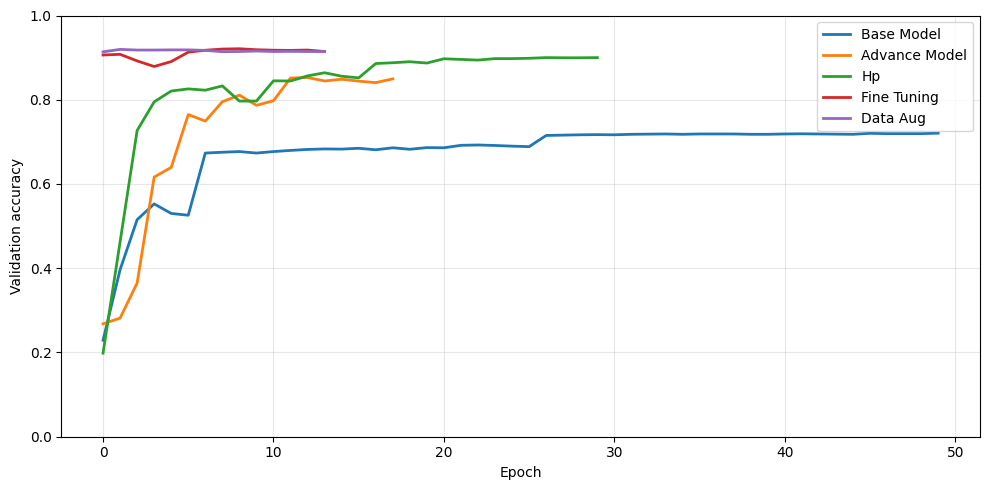

In [65]:
results = pd.DataFrame([
    evaluate_and_log(MODELS_DIR/'base_model.keras',   'base_model'),
    evaluate_and_log(MODELS_DIR/'advance_model.keras','advance_model'),
    evaluate_and_log(MODELS_DIR/'hp.keras',           'hp'),
    evaluate_and_log(MODELS_DIR/'fine_tuning.keras',  'fine_tuning'),
    evaluate_and_log(MODELS_DIR/'data_aug.keras',     'data_aug')
])

display(results.style.background_gradient(cmap='Reds', subset=['Test_Accuracy'])
                  .format({'Test_Accuracy':'{:.3f}'}))

plt.figure(figsize=(10,5))
for m, color in zip(['base_model','advance_model','hp','fine_tuning','data_aug'],
                    ['tab:blue','tab:orange','tab:green','tab:red','tab:purple']):
    hist = json.load(open(HIST_DIR/f'{m}.json'))
    plt.plot(hist['val_accuracy'], label=m.replace('_',' ').title(), linewidth=2)
plt.legend(); plt.ylabel('Validation accuracy'); plt.xlabel('Epoch'); plt.ylim(0,1); plt.grid(alpha=.3)
plt.tight_layout(); plt.show()

# 10. Visualización rápida de predicciones con matplotlib

Model: "model_with_augmentation"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                      ┃ Output Shape             ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)        │ (None, 150, 150, 3)      │             0 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ data_augmentation (Sequential)    │ (None, 150, 150, 3)      │             0 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ MobileNetV2_finetune (Functional) │ (None, 6)                │     2,422,726 │
└───────────────────────────────────┴──────────────────────────┴───────────────┘

 Total params: 6,475,096 (24.70 MB)

 Trainable params: 2,026,182 (7.73 MB)

 Non-trainable params: 396,544 (1.51 MB)

 Optimizer params: 4,052,370 (15.46 MB)

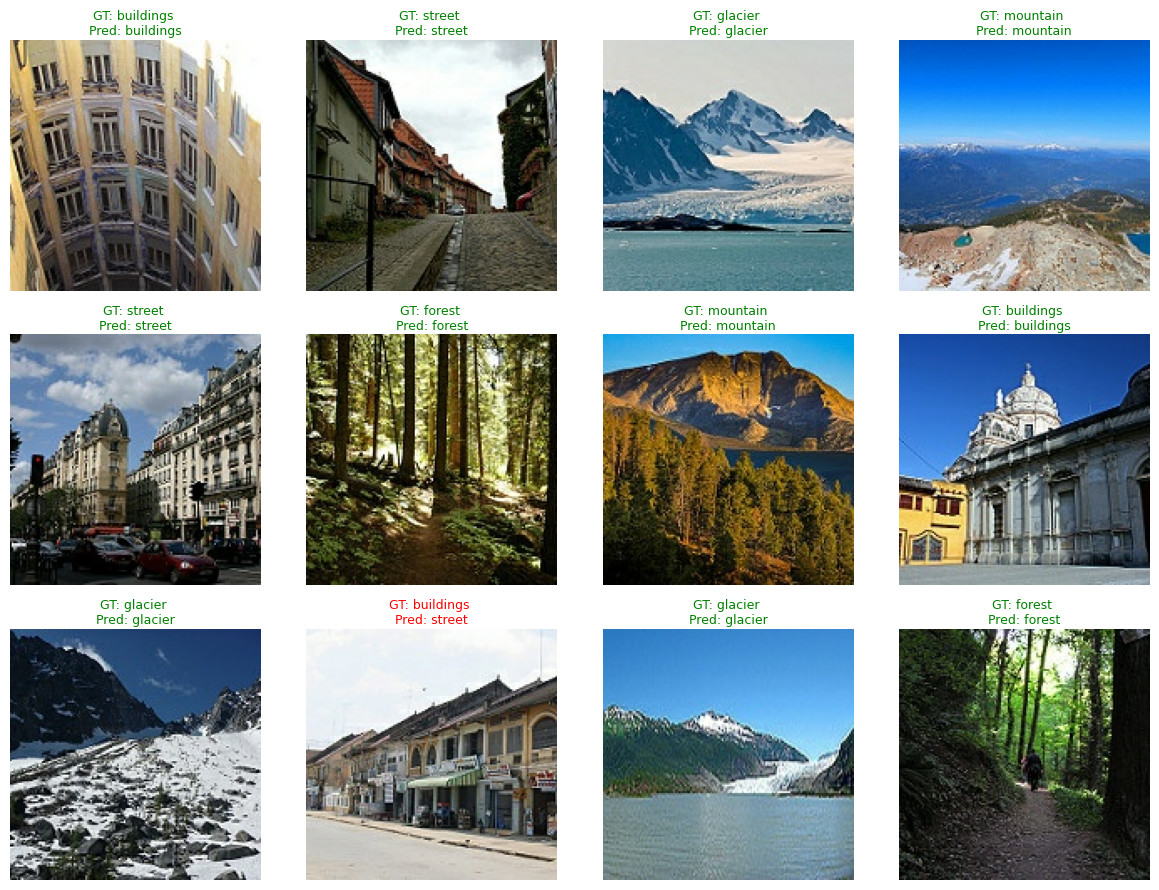

In [66]:
model  = tf.keras.models.load_model(MODELS_DIR / 'data_aug.keras')
model.summary(line_length=80)

NUM_IMAGES = 12
test_iter  = test_ds.unbatch().take(NUM_IMAGES)

plt.figure(figsize=(12, 9))
for idx, (img, true_lab) in enumerate(test_iter):
    pred_prob   = model.predict(img[tf.newaxis, ...], verbose=0)
    pred_label  = tf.argmax(pred_prob, axis=1).numpy()[0]

    ax = plt.subplot(3, 4, idx + 1)
    plt.imshow(img.numpy().astype("uint8"))
    ax.axis("off")

    correct = (pred_label == true_lab.numpy())
    color   = "green" if correct else "red"
    ax.set_title(
        f"GT: {class_names[true_lab]} \nPred: {class_names[pred_label]}",
        fontsize=9, color=color, pad=4
    )

plt.tight_layout()
plt.show()
